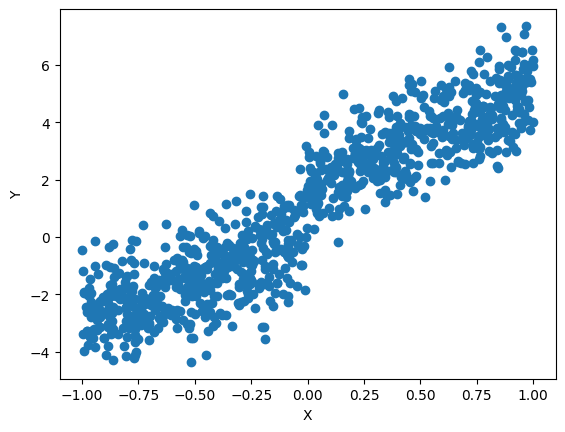

In [2]:
# ライブラリのインポート
# ------------------------------------------------------------
# ・numpy, pandas, matplotlib はいつもの科学計算セット。
# ・rdrobust, rddensity は回帰不連続デザイン（Regression Discontinuity Design, RDD）
#   を推定・診断するための専用ライブラリ。
#   - rdrobust: 局所線形回帰による処置効果（ジャンプ）の推定
#   - rddensity: カットオフ周りの密度の不連続性（マニピュレーションの有無）の検定
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdrobust
import rddensity

# 再現性のためにランダムシードを設定
# ------------------------------------------------------------
# 乱数を用いて疑似データを生成するので、結果を再現できるように固定。
np.random.seed(0)

# サンプルデータを生成
# ------------------------------------------------------------
# n : 観測データの数（サンプルサイズ）
n = 1000

# X : 「強制変数（running variable, forcing variable）」に相当。
#     - RDD では、X の値がカットオフを境にして処置が決まる。
#     - 例）テスト点数 X が 0 を超えたら奨学金付与、といった状況。
# 今回は -1 〜 1 の一様分布から生成している。
X = np.random.uniform(-1, 1, size=n)

# threshold : カットオフ値（cutoff）
# ------------------------------------------------------------
# X が threshold を超えるかどうかで処置割付が決まると仮定する。
threshold = 0

# treatment : 処置割当変数 D（0/1）
# ------------------------------------------------------------
# X が threshold より大きい場合に処置 D=1、それ以外は D=0 とする。
# これは「sharp RDD」（カットオフで処置確率が 0→1 に飛ぶタイプ）を想定した割付ルール。
treatment = (X > threshold).astype(int)

# Y : 結果変数（アウトカム）
# ------------------------------------------------------------
# 構造モデルとして
#   Y = 3 * X + 2 * D + ε
# を仮定している形になっている。
# ・3 * X       : running variable X の連続的な効果（ベースラインの傾き）
# ・2 * treatment:
#       カットオフを超えて処置を受けたことによる「ジャンプ」の大きさ（局所的処置効果）
#       → threshold 近傍では、処置群と対照群の間に平均で 2 の差が生じるように設計。
# ・np.random.normal(size=n):
#       誤差項 ε ~ N(0,1)（観測ノイズ）
Y = 3 * X + 2 * treatment + np.random.normal(size=n)

# データフレームの作成
# ------------------------------------------------------------
# RDD の推定では「Y（アウトカム）」「X（強制変数）」「処置 D」を
# 1 つのデータフレームで扱うと便利なので、この段階で整形しておく。
df = pd.DataFrame({"Y": Y, "X": X, "treatment": treatment})

# データの可視化
# ------------------------------------------------------------
# X（強制変数）と Y（アウトカム）の散布図を描く。
# ・理論的には、X=0 のところで Y の条件付き期待値に「ジャンプ」があれば、
#   それが局所的な因果効果（局所平均処置効果）として解釈できる。
# ・このプロットでは、X=0 を境に点の位置が縦にずれて見えるはずで、
#   その「段差」がおおよそ 2 になるように合成されている。
# 後で rdrobust を使って推定するジャンプのサイズを視覚的に確認するための第一歩。
plt.scatter(df["X"], df["Y"])
plt.xlabel("X")  # X軸のラベル（running variable）
plt.ylabel("Y")  # Y軸のラベル（outcome）
plt.show()  # グラフの表示

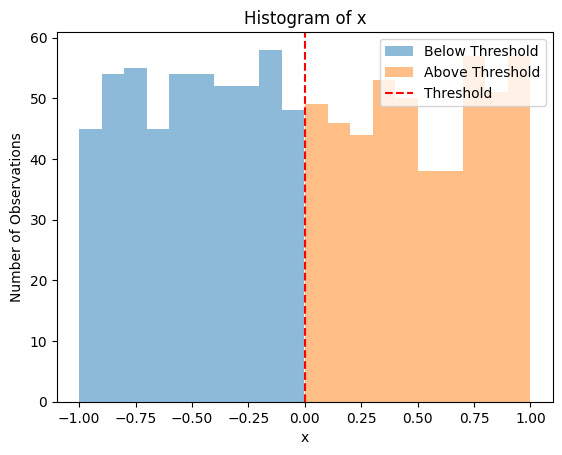

In [3]:
# ------------------------------------------------------------
# 強制変数 X のヒストグラム（cutoff 前後の分布の確認）
# ------------------------------------------------------------
# 回帰不連続デザイン（RDD）の重要な識別仮定の一つに
# 「cutoff 周りで X の分布が連続（≒ マニピュレーションがない）」
# という密度連続性の仮定がある。
#
# もし個体が「わざと cutoff を越えるように X を操作している」場合、
# cutoff 近傍で X の分布に不自然な谷や山が現れ、
# RDD による因果効果の識別が怪しくなる。
#
# 以下のコードでは、
#   - threshold 未満の個体（control 側）
#   - threshold 以上の個体（treated 側）
# に分けて X のヒストグラムを描くことで、
# cutoff 前後で X の分布に大きな不連続がないかを目視でチェックしている。

# threshold より左側（cutoff 未満）の X のヒストグラム
# bins=10: X の範囲を 10 ビンに分割して頻度をカウント
# alpha=0.5: 透過度を 0.5 にして、2 つのヒストグラムが重なっても視認しやすくする
plt.hist(df[df["X"] < threshold]["X"], bins=10, alpha=0.5, label="Below Threshold")

# threshold 以上（cutoff 右側）の X のヒストグラム
# 同じビン数・同じ設定で描くことで、左右の分布形状を比較しやすくする。
plt.hist(df[df["X"] >= threshold]["X"], bins=10, alpha=0.5, label="Above Threshold")

# 赤い破線で cutoff（threshold）の位置を明示
# RDD の文脈では、この縦線を境に処置割付ルールが変わることを示す。
plt.axvline(x=threshold, color="r", linestyle="--", label="Threshold")

# 軸ラベルとタイトルの設定
plt.xlabel("x")  # 横軸: 強制変数 X
plt.ylabel("Number of Observations")  # 縦軸: 各ビン内の観測数
plt.title("Histogram of x")  # 図タイトル

# 凡例の表示（Below / Above Threshold / Threshold の 3 つ）
plt.legend()

# ヒストグラムの描画
# この図を見て、cutoff 付近で「片側だけ異様に観測が多い／少ない」といった
# 不自然な形がないかを確認する。
# より形式的には rddensity（McCrary test）を使って密度の不連続を検定するが、
# ここではその前段としてのグラフィカル診断になっている。
plt.show()

In [6]:
# ------------------------------------------------------------
# 密度の不連続性検定（McCrary test の実装）
# ------------------------------------------------------------
# rddensity.rddensity:
#   回帰不連続デザイン（RDD）における「強制変数 X の密度が
#   cutoff c で連続かどうか」を検定する関数。
#
# 理論背景：
#   sharp RDD で局所的な因果効果 τ を同定するためには、
#   cutoff c を挟んで X の分布が「なめらか（連続）」である、
#   という仮定がよく使われる。
#
#   直感的には、
#     - 人々が cutoff を「狙って」X を操作していない
#     - cutoff 直前と直後の人々は、潜在的には似たような集団
#   であることを意味する。
#
#   もし cutoff 周辺で X の密度 f_X(x) に不連続ジャンプがあれば、
#     lim_{x↑c} f_X(x) ≠ lim_{x↓c} f_X(x)
#   となり、X の「マニピュレーション」が疑われ、RDD による
#   因果効果の識別が危うくなる。
#
# rddensity.rddensity(X, c=0) は、これを統計的に検定する：
#
#   帰無仮説 H0:
#       密度は cutoff c で連続（マニピュレーションなし）
#
#   対立仮説 H1:
#       密度は cutoff c で不連続（マニピュレーションあり）
#
# ここでは
#   - X : 強制変数（running variable）
#   - c : cutoff（ここでは 0）
# を与えて、cutoff=0 周辺で密度が飛んでいないかをチェックする。
rddensity.rddensity(X, c=0)

Manipulation testing using local polynomial density estimation
Number of obs:                              1000
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 0                               Left of c             Right of c
Number of obs:                            517                    483
Eff. number of obs:                       184                    153
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                                0.3446                 0.3336

Method:                                     T                P > |T|
Robust                                  0.963                 0.3356

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    

In [8]:
# ------------------------------------------------------------
# 局所線形 RDD 推定（rdrobust）
# ------------------------------------------------------------
# rdrobust.rdrobust:
#   回帰不連続デザイン (RDD) における「cutoff 直近での平均アウトカムのジャンプ」
#   を局所多項式（デフォルトは局所線形）で推定する関数。
#
#   ここで想定している sharp RDD の設定はおおよそ次の通り：
#     - X : 強制変数 (running variable)
#     - c : cutoff（この値を境に処置が変わる）
#     - Y : 結果変数 (outcome)
#     - 処置 D は「X >= c なら 1, そうでなければ 0」というルールで決まる
#
#   局所平均の定義としては、
#     - 左側の極限   mu_minus = lim_{x -> c-} E[Y | X = x]
#     - 右側の極限   mu_plus  = lim_{x -> c+} E[Y | X = x]
#   を、それぞれ cutoff 近傍のデータだけを用いて推定し、
#     tau = mu_plus - mu_minus
#   を「cutoff における局所平均処置効果 (Local Average Treatment Effect)」
#   として推定する。
#
#   rdrobust のコアは
#     - X の左右それぞれについて、多項式回帰（通常は1次：局所線形）を実行
#     - カーネル重み（デフォルトは三角カーネル）で cutoff 周辺の観測に重み付け
#     - bandwidth をデータ駆動で最適化（MSE 最小化など）
#     - バイアス補正込みの「robust」標準誤差・信頼区間を報告
#   という一連の処理をまとめたもの。
#
# 引数の意味：
#   - Y: 1次元のアウトカムベクトル（例: 成績、売上、体重など）
#   - X: 1次元の強制変数ベクトル（例: スコア、所得、距離など）
#   - c: cutoff (ここでは 0)。X がこの値を境に処置ルールが変わる。
#
# 戻り値 res_rd には
#   - 推定されたジャンプ tau_hat
#   - 標準誤差・t値・p値
#   - 95%信頼区間
#   - 左右の bandwidth や有効サンプル数
#   などが含まれており、RDD のメイン結果を要約してくれる。
#
# 注意点：
#   - この推定値を「因果効果」と解釈するためには、
#       (1) cutoff 周辺で X の密度が連続（先に rddensity で検定した仮定）
#       (2) ポテンシャルアウトカムが cutoff で連続
#       (3) SUTVA（干渉なし）
#     などが前提となる。
#   - したがって、rdrobust の結果は rddensity の結果や
#     X-Y 散布図・感度分析と合わせて解釈する必要がある。
rdrobust.rdrobust(Y, X, c=0)

Call: rdrobust
Number of Observations:                  1000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           517        483
Number of Unique Obs.            517        483
Number of Effective Obs.         112         97
Bandwidth Estimation            0.21       0.21
Bandwidth Bias                 0.362      0.362
rho (h/b)                       0.58       0.58

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       1.194    0.304    3.922   8.767e-05     [0.597, 1.791]
Robust                 -        -    3.091   1.994e-03     [0.403, 1.799]
